# environmental setup

In [13]:
# BASIC
import numpy as np
import xarray as xr
import pandas as pd

#xr.set_options(display_style="text") # make it look better when posted online. Comment to get nicer representation of xarrays
import os

# matplotlib
import matplotlib
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.tri as mtri
import matplotlib.dates as md
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib import ticker
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['axes.linewidth'] = 1.5

## color
from matplotlib import cm
import cmocean
import seaborn as sns

## cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point


# scipy
from scipy import stats
from scipy import optimize
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
from scipy.stats import binned_statistic
import scipy.spatial.qhull as qhull


# metpy
import metpy
import metpy.calc as mpcalc


# etc
import subprocess
import time
import datetime
from datetime import timedelta
import calendar


# Dask
import dask # Distributed data libary
from dask import delayed
from dask import compute
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from distributed import Client, progress # Libaray to orchestrate distributed resources
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

from pathlib import Path
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
import warnings
warnings.filterwarnings(action='ignore')



In [14]:
def bin_ave_2d(x_dat_in, y_dat_in, x_bin_in):
    '''
    '''
    x_dat,y_dat = x_dat_in.flatten(),y_dat_in.flatten()
    x_dim,y_dim = len(x_dat),len(y_dat)
    x_bin_dim = len(x_bin_in)

    z,zn,z_std = np.zeros((x_bin_dim-1)),np.zeros((x_bin_dim-1)),np.zeros((x_bin_dim-1))

    for xx in np.arange(x_bin_dim-1):
        var = []
        for ii in np.arange(x_dim):
            if (x_dat[ii]>=x_bin_in[xx]) & (x_dat[ii]<x_bin_in[xx+1]) & (~np.isnan(y_dat[ii])):
                var.append(y_dat[ii])
                z[xx] = z[xx] + y_dat[ii]
                zn[xx] = zn[xx] + 1
        z[xx] = np.nanmean(np.array(var))
        z_std[xx] = np.nanstd(np.array(var))

    y_out = z  #/zn
    x_out = (x_bin_in[:-1]+x_bin_in[1:])/2.
    
    return x_out, y_out, z_std, zn

In [15]:
WORK_DIR = '~/python/land_atm_coupling/land-atm_coupling_publication/'

# data

In [16]:
dpath = f'{WORK_DIR}/data/CMIP6/'
land_frac = xr.open_mfdataset(f'{dpath}/bc_land_frac_2x2.nc')

dpath = f'{WORK_DIR}/data/dpp0066/'
box_pr_smi = xr.open_mfdataset(f'{dpath}/box_pr-smi_one_sigma.nc')
box_fin = box_pr_smi['box_xr']

### ICON

In [17]:
dpath = f'{WORK_DIR}/data/dpp0066/'

dataICON1  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_pr_2x2.nc')
dataICON2  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_hfls_2x2.nc')
dataICON3  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_hfss_2x2.nc')
dataICON4  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_run_2x2.nc')
dataICON5  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_rootsm_2x2.nc')
dataICON51 = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_rsds_2x2.nc')
dataICON52 = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_rsus_2x2.nc')
dataICON53 = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_rlds_2x2.nc')
dataICON54 = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_rlus_2x2.nc')
dataICON6  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_drain_2x2.nc')
dataICON7  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_smi_2x2.nc')
dataICON8  = xr.open_mfdataset(f'{dpath}/dpp0066_2020_full_daily_w_soil_sl0_2x2.nc')


dataICON = xr.merge([dataICON1, dataICON2, dataICON3, dataICON4, dataICON5, 
                     dataICON51, dataICON52, dataICON53, dataICON54, 
                     dataICON6, dataICON7, dataICON8,])

dataICON = dataICON.sel(time=slice('2020-06-01','2020-08-31'))
dataICON

<xarray.Dataset>
Dimensions:              (time: 92, lon: 180, lat: 90)
Coordinates:
  * time                 (time) datetime64[ns] 2020-06-01 ... 2020-08-31
  * lon                  (lon) float64 -179.0 -177.0 -175.0 ... 177.0 179.0
  * lat                  (lat) float64 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
Data variables: (12/13)
    pr                   (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    hfls                 (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    hfss                 (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    run                  (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    rootsm               (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    rsds                 (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    ...                   ...
    rlds                 (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    rlus                 (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    drain                (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    smi                  (time, lat, lon) float64 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    hydro_w_soil_sl_box  (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
    hydro_w_ice_sl_box   (time, lat, lon) float32 dask.array<chunksize=(92, 90, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Nov 28 14:33:25 2022: cdo remap,/work/mh0731/m300793/da...
    CDO:          Climate Data Operators version 2.0.3 (https://mpimet.mpg.de...

In [18]:
dpath = f'{WORK_DIR}/data/dpp0066/'
dataICON_init = xr.open_mfdataset(dpath+'/bc_land_soil_2x2.nc')
dataICON_frac = xr.open_mfdataset(dpath+'/bc_land_frac_2x2.nc')
dataICON_ele  = xr.open_mfdataset(dpath+'/icon_grid_0015_R02B09_G_sea_land_ele_2x2.nc')
dataICON_sso  = xr.open_mfdataset(dpath+'/bc_land_sso_2x2.nc')
dataICON_phy  = xr.open_mfdataset(dpath+'/bc_land_phys_2x2.nc')

### CMIP

In [19]:
dpath     = f'{WORK_DIR}/data/CMIP6/'

dataCMIP1  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_pr_2x2.nc')
dataCMIP2  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_hfls_2x2.nc')
dataCMIP3  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_hfss_2x2.nc')
dataCMIP4  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_runoff_2x2.nc')
dataCMIP5  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_rzwc_2x2.nc')
dataCMIP51 = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_rsds_2x2.nc')
dataCMIP52 = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_rsus_2x2.nc')
dataCMIP53 = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_rlds_2x2.nc')
dataCMIP54 = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_rlus_2x2.nc')
dataCMIP6  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_drain_2x2.nc')
dataCMIP7  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_smi_2x2.nc')
dataCMIP8  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_w_soil_sl_2x2.nc').isel(soil_depth_water=0)

dataCMIP = xr.merge([dataCMIP1, dataCMIP2, dataCMIP3, dataCMIP4, dataCMIP5, 
                     dataCMIP51, dataCMIP52, dataCMIP53, dataCMIP54, 
                     dataCMIP6, dataCMIP7, dataCMIP8])
dataCMIP = dataCMIP.sel(time=dataCMIP.time.dt.month.isin([6, 7, 8]))
dataCMIP

<xarray.Dataset>
Dimensions:              (time: 5520, lon: 180, lat: 90)
Coordinates:
  * time                 (time) datetime64[ns] 2000-06-01 ... 2059-08-31
  * lon                  (lon) float64 -179.0 -177.0 -175.0 ... 177.0 179.0
  * lat                  (lat) float64 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
    soil_depth_water     float64 0.0325
Data variables: (12/13)
    pr                   (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    hfls                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    hfss                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    mrro                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    rzwc                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    rsds                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    ...                   ...
    rlds                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    rlus                 (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    hydro_drainage_box   (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    smi                  (time, lat, lon) float64 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    hydro_w_soil_sl_box  (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
    hydro_w_ice_sl_box   (time, lat, lon) float32 dask.array<chunksize=(5520, 90, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Oct 21 15:15:30 2022: cdo remap,grid_2x2.txt,weight_2x2...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [20]:
dpath = f'{WORK_DIR}/data/CMIP6/'
dataCMIP_init = xr.open_mfdataset(dpath+'/bc_land_soil_2x2.nc')
dataCMIP_frac = xr.open_mfdataset(dpath+'/bc_land_frac_2x2.nc')
dataCMIP_ele  = xr.open_mfdataset(dpath+'/icon_grid_0013_R02B04_G_sea_land_ele_2x2.nc')
dataCMIP_sso  = xr.open_mfdataset(dpath+'/bc_land_sso_2x2.nc')
dataCMIP_phy  = xr.open_mfdataset(dpath+'/ICON-ESM-LR_full_daily_lai_2x2.nc')

In [21]:
CMIP_lon, CMIP_lat = np.meshgrid(dataICON['lon'], dataICON['lat'])

### computation

In [22]:
icon_pr = dataICON['pr'].mean('time')

cmip_pr = dataCMIP['pr'].mean('time') * 86400.

icon_land = dataICON_frac['land']
cmip_land = dataCMIP_frac['land']
icon_ele = dataICON_ele['cell_elevation']
cmip_ele = dataCMIP_ele['cell_elevation']
icon_orostd = dataICON_sso['orostd']
cmip_orostd = dataCMIP_sso['orostd']

icon_dat_lai = dataICON_phy['lai_clim']

time_init  = "2020-01-01 00:00:00" 
tdim = len(dataICON_phy['time'].values)
icon_dat_lai['time'] = pd.date_range(time_init, periods=tdim, freq='MS') + pd.DateOffset(days=14)
icon_dat_lai_daily = icon_dat_lai.resample(time='1D').interpolate('linear').sel(time=slice("2020-06-01","2020-08-31"))

In [23]:
icon_y1 = xr.where( (box_fin==1)&(cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), dataICON['hfls'], np.NaN)
icon_y2 = xr.where( (box_fin==1)&(cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), dataICON['hfss'], np.NaN)
icon_P   = xr.where( (box_fin==1)&(cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), dataICON['pr'], np.NaN)

icon_corr_lh_pr      = xr.where((box_fin==1)&(cmip_pr>=.1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                                xr.corr(dataICON['pr'], icon_y1, dim='time'), np.NaN) #.values
icon_corr_sh_pr      = xr.where((box_fin==1)&(cmip_pr>=.1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                                xr.corr(dataICON['pr'], icon_y2, dim='time'), np.NaN) #.values

In [24]:
cmip_y1 = xr.where( (box_fin==1)&(icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake']<0.1), dataCMIP['hfls'], np.NaN)
cmip_y2 = xr.where( (box_fin==1)&(icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake']<0.1), dataCMIP['hfss'], np.NaN)
cmip_P   = xr.where( (box_fin==1)&(icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake']<0.1), dataCMIP['pr']*86400., np.NaN)

cmip_corr_lh_pr      = xr.where((box_fin==1)&(icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                                xr.corr(dataCMIP['pr']*86400., cmip_y1, dim='time'), np.NaN) #.values
cmip_corr_sh_pr      = xr.where((box_fin==1)&(icon_pr>=.1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                                xr.corr(dataCMIP['pr']*86400., cmip_y2, dim='time'), np.NaN) #.values

In [25]:
icon_smi = xr.where((box_fin==1)&(cmip_pr>=.1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1),
                    dataICON['smi'], np.NaN)

icon_corr_lh_smi  = xr.where((box_fin==1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataICON['smi'], icon_y1, dim='time'), np.NaN) #.values
icon_corr_pr_smi  = xr.where((box_fin==1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataICON['smi'], dataICON['pr'], dim='time'), np.NaN) #.values


cmip_smi = xr.where((box_fin==1)&(cmip_pr>=.1)&(icon_pr>=.1)&( land_frac['fract_lake'] < 0.1),
                    dataCMIP['smi'], np.NaN)

cmip_corr_lh_smi  = xr.where((box_fin==1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataCMIP['smi'], cmip_y1, dim='time'), np.NaN) #.values
cmip_corr_pr_smi  = xr.where((box_fin==1)&(cmip_pr>=.1)&( land_frac['fract_lake'] < 0.1), 
                             xr.corr(dataCMIP['smi'], dataCMIP['pr']*86400., dim='time'), np.NaN) #.values


In [26]:
temp_pr_smi = []
temp_lh_smi = []
temp_sh_pr  = []
temp_lh_pr  = []

for tt in np.arange(2000,2060):
    pr  = dataCMIP['pr'].sel(time=str(tt))*86400.
    smi = dataCMIP['smi'].sel(time=str(tt))
    lh  = cmip_y1.sel(time=str(tt))
    sh  = cmip_y2.sel(time=str(tt))

    corr_temp = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), 
                                xr.corr(pr, smi, dim='time'), np.NaN)
    temp_pr_smi.append(corr_temp)
    
    corr_temp = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), 
                                xr.corr(lh, smi, dim='time'), np.NaN)
    temp_lh_smi.append(corr_temp)

    corr_temp = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), 
                                xr.corr(sh, pr, dim='time'), np.NaN)
    temp_sh_pr.append(corr_temp)

    corr_temp = xr.where((cmip_pr>=.1)&(icon_pr>=.1)&(land_frac['fract_lake']<0.1), 
                                xr.corr(lh, pr, dim='time'), np.NaN)
    temp_lh_pr.append(corr_temp)

In [27]:
internal_pr_smi = xr.concat(temp_pr_smi,dim='time')
internal_pr_smi['time'] =  pd.date_range('2000-06-01', periods=60, freq='1Y')

internal_lh_smi = xr.concat(temp_lh_smi,dim='time')
internal_lh_smi['time'] =  pd.date_range('2000-06-01', periods=60, freq='1Y')

internal_sh_pr = xr.concat(temp_sh_pr,dim='time')
internal_sh_pr['time'] =  pd.date_range('2000-06-01', periods=60, freq='1Y')

internal_lh_pr = xr.concat(temp_lh_pr,dim='time')
internal_lh_pr['time'] =  pd.date_range('2000-06-01', periods=60, freq='1Y')

# Plot

In [28]:
# Fig. a
xmina, xmaxa, dxa = -1, 2, 0.1
xdata1, ydata1 = icon_smi.mean('time').values, icon_corr_lh_smi.values
xdata2, ydata2 = cmip_smi.mean('time').values, internal_lh_smi.mean('time').values
x_outa1, y_outa1, z_outa1, zna1 = bin_ave_2d(xdata1, ydata1, np.arange(xmina,xmaxa+dxa,dxa))
x_outa2, y_outa2, z_outa2, zna2 = bin_ave_2d(xdata2, ydata2, np.arange(xmina,xmaxa+dxa,dxa))

# Fig. c
xminc, xmaxc, dxc = -1, 2, 0.1
xdatc1, ydatc1 = icon_smi.mean('time').values, icon_corr_lh_pr.values
xdatc2, ydatc2 = cmip_smi.mean('time').values, internal_lh_pr.mean('time').values
x_outc1, y_outc1, z_outc1, znc1 = bin_ave_2d(xdatc1, ydatc1, np.arange(xminc,xmaxc+dxc,dxc))
x_outc2, y_outc2, z_outc2, znc2 = bin_ave_2d(xdatc2, ydatc2, np.arange(xminc,xmaxc+dxc,dxc))

xdatc1, rdatc1 = icon_smi.mean('time').values, icon_corr_sh_pr.values
xdatc2, rdatc2 = cmip_smi.mean('time').values, internal_sh_pr.mean('time').values
x_outc1, r_outc1, z_outc1, znc1 = bin_ave_2d(xdatc1, rdatc1, np.arange(xminc,xmaxc+dxc,dxc))
x_outc2, r_outc2, z_outc2, znc2 = bin_ave_2d(xdatc2, rdatc2, np.arange(xminc,xmaxc+dxc,dxc))


# Fig. b
from scipy.stats import binned_statistic
xmin, xmax, dx = -1, 20, 0.1

xdatb1, ydatb1 = icon_y1.values.flatten()*86400./2.5008e6, icon_P.values.flatten()
xdatb2, ydatb2 = cmip_y1.values.flatten()*86400./2.5008e6, cmip_P.values.flatten()

xx_1 = xdatb1.flatten()
yy_1 = ydatb1.flatten()
yy_2 = yy_1[~np.isnan(xx_1)]
xx_2 = xx_1[~np.isnan(xx_1)]
xx = xx_2[~np.isnan(yy_2)]
yy = yy_2[~np.isnan(yy_2)]

bin_means = binned_statistic(xx, yy, bins=np.arange(xmin, xmax+dx, dx), range=(xmin, xmax))
bin_stds  = binned_statistic(xx, yy, statistic='std', bins=np.arange(xmin, xmax+dx, dx), range=(xmin, xmax))
x_outb1 = np.diff(bin_means[1])/2.+bin_means[1][:-1]
y_outb1 = bin_means[0]
zn_bin1= bin_means[1]
znb1    = bin_means[2]
std_outb1 = bin_stds[0]

xx_1 = xdatb2.flatten()
yy_1 = ydatb2.flatten()
yy_2 = yy_1[~np.isnan(xx_1)]
xx_2 = xx_1[~np.isnan(xx_1)]
xx = xx_2[~np.isnan(yy_2)]
yy = yy_2[~np.isnan(yy_2)]

bin_means = binned_statistic(xx, yy, bins=np.arange(xmin, xmax+dx, dx), range=(xmin, xmax))
bin_stds  = binned_statistic(xx, yy, statistic='std', bins=np.arange(xmin, xmax+dx, dx), range=(xmin, xmax))
x_outb2 = np.diff(bin_means[1])/2.+bin_means[1][:-1]
y_outb2 = bin_means[0]
zn_bin2= bin_means[1]
znb2    = bin_means[2]
std_outb2 = bin_stds[0]

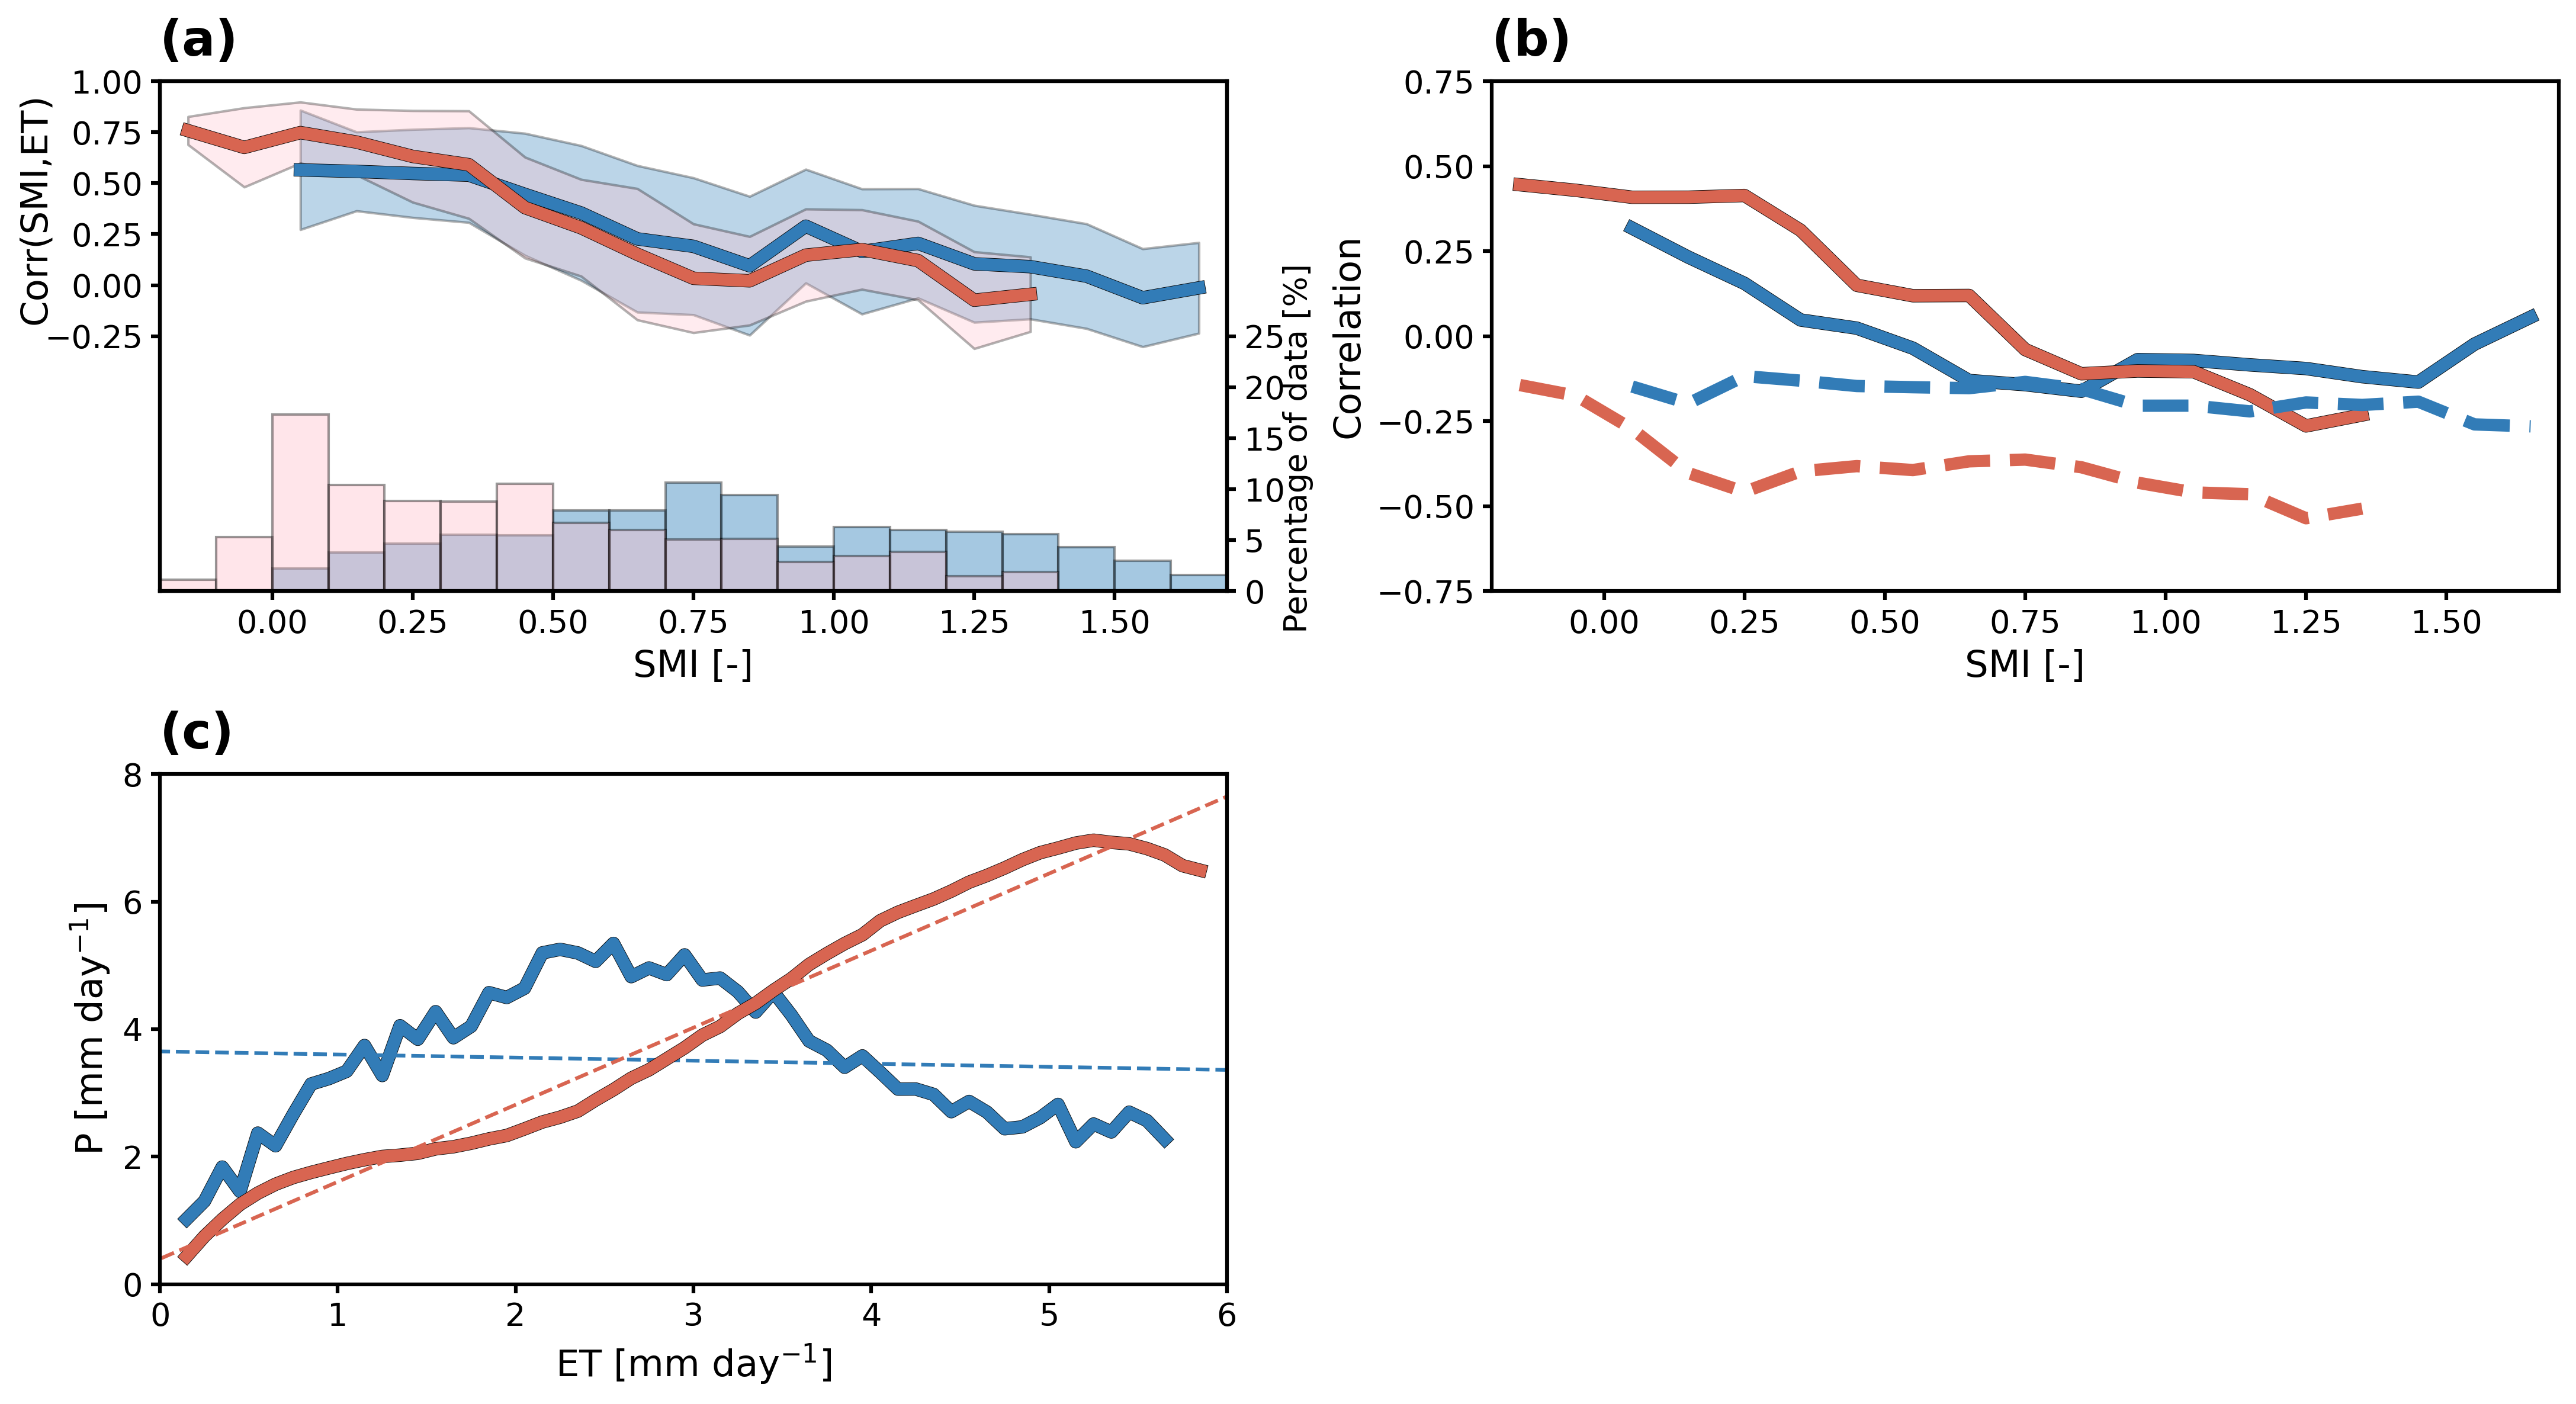

In [29]:
txt_x, txt_y = 0.0, 1.05

rmax, cmax = 2, 3
fig, ax = plt.subplots(nrows=rmax,ncols=cmax, figsize=(22,8),)

## Fig. a
rr, cc = 0, 0
y_outa1 = np.where(zna1>=np.sum(zna1) * 0.01, y_outa1, np.NaN)
x_outa1 = np.where(zna1>=np.sum(zna1) * 0.01, x_outa1, np.NaN)
z_outa1 = np.where(zna1>=np.sum(zna1) * 0.01, z_outa1, np.NaN)
ax[rr,cc].plot(x_outa1, y_outa1, c='k',                 linewidth=5.4)
ax[rr,cc].plot(x_outa1, y_outa1, c=plt.cm.RdBu([0.85]), linewidth=5)
ax[rr,cc].fill_between(x_outa1, y_outa1-z_outa1, y_outa1+z_outa1 ,alpha=0.3, color='C0', edgecolor='k')
ax[rr,cc].set_xlim(-0.2, 1.7)
ax[rr,cc].set_ylim(-1.5, 1)
ax[rr,cc].set_yticks(np.arange(-0.25,1.0+0.25,0.25))
ax[rr,cc].set_xlabel('SMI [-]', fontsize=15)
ax[rr,cc].set_ylabel('Corr(SMI,ET)', fontsize=15)
ax[rr,cc].yaxis.set_label_coords(-0.10,0.75)
ax[rr,cc].text(txt_x, txt_y, '(a)', transform=ax[rr,cc].transAxes, size=20, weight='bold')

y_outa2 = np.where(zna2>=np.sum(zna2) * 0.01, y_outa2, np.NaN)
x_outa2 = np.where(zna2>=np.sum(zna2) * 0.01, x_outa2, np.NaN)
z_outa2 = np.where(zna2>=np.sum(zna2) * 0.01, z_outa2, np.NaN)
ax[rr,cc].plot(x_outa2, y_outa2, c='k',                 linewidth=5.4)
ax[rr,cc].plot(x_outa2, y_outa2, c=plt.cm.RdBu([0.21]), linewidth=5)
ax[rr,cc].fill_between(x_outa2, y_outa2-z_outa2, y_outa2+z_outa2 ,alpha=0.3, facecolor='pink', edgecolor='k')

ax2 = ax[rr,cc].twinx()
xx_1 = x_outa1
yy_1 = zna1
yy_2 = yy_1[~np.isnan(xx_1)]
xx_2 = xx_1[~np.isnan(xx_1)]
xx = xx_2[~np.isnan(yy_2)]
yy = yy_2[~np.isnan(yy_2)]
ax2.bar(xx, yy/np.sum(zna1)*100., width=dxa, alpha=0.4, color='C0', edgecolor='k')

xx_1 = x_outa2
yy_1 = zna2
yy_2 = yy_1[~np.isnan(xx_1)]
xx_2 = xx_1[~np.isnan(xx_1)]
xx = xx_2[~np.isnan(yy_2)]
yy = yy_2[~np.isnan(yy_2)]
ax2.bar(xx, yy/np.sum(zna2)*100., width=dxa, alpha=0.4, color='pink', edgecolor='k')

ax2.set_ylim(0, 50)
ax2.set_yticks(np.arange(0,25+5,5))
ax2.set_ylabel('Percentage of data [%]', fontsize=13)
ax2.yaxis.set_label_coords(1.052,0.28)

ax[rr,cc].xaxis.set_tick_params(width=1.5, labelsize=13)
ax[rr,cc].yaxis.set_tick_params(width=1.5, labelsize=13)
ax2      .yaxis.set_tick_params(width=1.5, labelsize=13)

## Fig. b
rr, cc = 0, 1
y_outc1 = np.where(znc1>=np.sum(znc1) * 0.01, y_outc1, np.NaN)
x_outc1 = np.where(znc1>=np.sum(znc1) * 0.01, x_outc1, np.NaN)
z_outc1 = np.where(znc1>=np.sum(znc1) * 0.01, z_outc1, np.NaN)
ax[rr,cc].plot(x_outc1, y_outc1, c='k',                 linewidth=5.4)
ax[rr,cc].plot(x_outc1, y_outc1, c=plt.cm.RdBu([0.85]), linewidth=5)
ax[rr,cc].set_xlim(-0.2, 1.7)
ax[rr,cc].set_ylim(-0.75, 0.75)
ax[rr,cc].set_yticks(np.arange(-0.75,0.75+0.25,0.25))
ax[rr,cc].set_xlabel('SMI [-]', fontsize=15)
ax[rr,cc].set_ylabel('Correlation', fontsize=15)
ax[rr,cc].text(txt_x, txt_y, '(b)', transform=ax[rr,cc].transAxes, size=20, weight='bold')


y_outc2 = np.where(znc2>=np.sum(znc2) * 0.01, y_outc2, np.NaN)
x_outc2 = np.where(znc2>=np.sum(znc2) * 0.01, x_outc2, np.NaN)
z_outc2 = np.where(znc2>=np.sum(znc2) * 0.01, z_outc2, np.NaN)
ax[rr,cc].plot(x_outc2, y_outc2, c='k',                 linewidth=5.4)
ax[rr,cc].plot(x_outc2, y_outc2, c=plt.cm.RdBu([0.21]), linewidth=5)

r_outa2 = np.where(znc2>=np.sum(znc2) * 0.01, r_outc2, np.NaN)
ax[rr,cc].plot(x_outc2, r_outc2, c=plt.cm.RdBu([0.21]), linewidth=5, linestyle='--')
r_outc1 = np.where(znc1>=np.sum(znc1) * 0.01, r_outc1, np.NaN)
ax[rr,cc].plot(x_outc1, r_outc1, c=plt.cm.RdBu([0.85]), linewidth=5, linestyle='--')
ax[rr,cc].xaxis.set_tick_params(width=1.5, labelsize=13)
ax[rr,cc].yaxis.set_tick_params(width=1.5, labelsize=13)


## Fig. c
rr, cc = 1, 0
bin_len = np.arange(xmin, xmax+dx, dx).shape[0]
yval, xval = np.histogram(znb1, bins=np.arange(bin_len))
xval = np.diff(xval)/2.+xval[:-1]

x_msk1 = np.where(yval>=np.sum(yval) * 0.003, x_outb1, np.NaN )
ax[rr,cc].plot(x_msk1, y_outb1, c='k',linewidth=5.4)
ax[rr,cc].plot(x_msk1, y_outb1, c=plt.cm.RdBu([0.85]),linewidth=5)

ax[rr,cc].set_xlim(-0.0, 6)
ax[rr,cc].set_ylim(-0.0, 8)
ax[rr,cc].set_yticks(np.arange(0, 8+2, 2))
ax[rr,cc].set_xlabel('ET [mm day$^{-1}$]', fontsize=15)
ax[rr,cc].set_ylabel('P [mm day$^{-1}$]', fontsize=15)
ax[rr,cc].text(txt_x, txt_y, '(c)', transform=ax[rr,cc].transAxes, size=20, weight='bold')

xx_1 = x_msk1.flatten()
yy_1 = y_outb1.flatten()
yy_1 = np.where(xx_1,yy_1,np.NaN)
xx_1 = np.where(xx_1,xx_1,np.NaN)
yy_2 = yy_1[~np.isnan(xx_1)]
xx_2 = xx_1[~np.isnan(xx_1)]
xx = xx_2[~np.isnan(yy_2)]
yy = yy_2[~np.isnan(yy_2)]
slope, intercept, r, p, se = stats.linregress(xx, yy)
ax[rr,cc].plot(np.arange(-400,500), slope*np.arange(-400,500)+intercept, c=plt.cm.RdBu([0.85]), linestyle='--')



yval, xval = np.histogram(znb2, bins=np.arange(bin_len))
xval = np.diff(xval)/2.+xval[:-1]

x_msk2 = np.where(yval>=np.sum(yval) * 0.003, x_outb2, np.NaN )
ax[rr,cc].plot(x_msk2, y_outb2, c='k',linewidth=5.4)
ax[rr,cc].plot(x_msk2, y_outb2, c=plt.cm.RdBu([0.21]),linewidth=5)

xx_1 = x_msk2.flatten()
yy_1 = y_outb2.flatten()
yy_1 = np.where(xx_1,yy_1,np.NaN)
xx_1 = np.where(xx_1,xx_1,np.NaN)
yy_2 = yy_1[~np.isnan(xx_1)]
xx_2 = xx_1[~np.isnan(xx_1)]
xx = xx_2[~np.isnan(yy_2)]
yy = yy_2[~np.isnan(yy_2)]
slope, intercept, r, p, se = stats.linregress(xx, yy)
ax[rr,cc].plot(np.arange(-400,500), slope*np.arange(-400,500)+intercept, c=plt.cm.RdBu([0.21]), linestyle='--')

ax[rr,cc].xaxis.set_tick_params(width=1.5, labelsize=13)
ax[rr,cc].yaxis.set_tick_params(width=1.5, labelsize=13)

rr, cc = 0, 2
ax[rr, cc].set_visible(False)
rr, cc = 1, 1
ax[rr, cc].set_visible(False)
rr, cc = 1, 2
ax[rr, cc].set_visible(False)

matplotlib.rcParams['axes.linewidth'] = 1.5
plt.tight_layout()